# Carcinogenesis

After having settled the ground for working with DL-Learner as a XAI model, either as a white-box or surrogate model, we set a second experiment with real world data on potentially carcinogenic compounds. The data is described in chapter 3 of the statement, and as it is available in OWL format there is no necessity to preprocess it in any way.

The schema of the vocabulary is shown in the figure below.

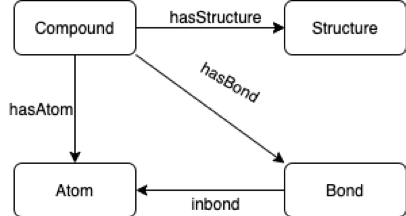

In [2]:
!pip install rdflib 

     |████████████████████████████████| 235kB 28.6MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 


In this following block of code we import all the necessary packages, we create the graph, parse the .nt file and set the namespace.

In [6]:
import rdflib
from rdflib import Graph, Namespace, Literal, XSD, URIRef
from rdflib.namespace import RDF, RDFS
from rdflib.plugins.sparql import prepareQuery
import random
import pandas as pd

g = Graph()
g.namespace_manager.bind('carcinogenesis', Namespace("http://dl-learner.org/carcinogenesis#"), override=False)
g.parse("https://raw.githubusercontent.com/pablodonisebri/TFM/master/Experiment2_Carcinogenesis/carcinogenesis.owl?token=ALO75734HETGGHMNJOA67NDA5RYAC",format="xml")
carcinogenesis = Namespace("http://dl-learner.org/carcinogenesis#")

# Query to check the expression for carcinogenic compounds.

In the figure below we have the symbolic expression that we are going to implement as an ASK type query to check the different compounds in the data base.


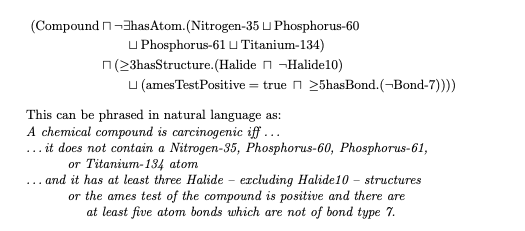

The expression is broken down into three different queries, the result of the three expressions is  combined in the function checkInstance, that receives the graph and the instance to be checked.



*   Query 1 (*compound_and_NotHasAtom*): 

 $$Compound \ \cap \neg \exists hasAtom.(Nitrogen-35 \cup Phosphorus-60 \cup Phosphorus-61 \cup Titanium-134)  $$


*   Query 2  (*hasStructure_Halide*):

$$ (\geq3 \ hasStructure.(Halide \cap \neg Halide10)) $$

 

*  Query 3 (*amesTest_and_hasBond_Not7*):

$$ amesTestPositive = True \ \cap \geq 5 hasBond.(\neg Bond-7) $$






In [7]:
#Query 1 
compound_and_NotHasAtom=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{

?compound a carcinogenesis:Compound.
{SELECT ?nAtom
          WHERE{
            {SELECT 
                (COUNT (DISTINCT ?atom) as ?nAtom)
            WHERE {
                ?compound carcinogenesis:hasAtom ?atom.
                ?atom a ?atomType.
                FILTER( ?atomType = carcinogenesis:Nitrogen-35 || 
                        ?atomType=  carcinogenesis:Titanium-134 || 
                        ?atomType=carcinogenesis:Phosphorus-60 || 
                        ?atomType =  carcinogenesis:Phosphorus-61)              
          }}FILTER(?nAtom = 0)}}
}
''',initNs = {"carcinogenesis": carcinogenesis})

#Query 2
hasStructure_Halide= prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{

{SELECT ?nstructure
WHERE{
          {SELECT 
              (COUNT(?structure) as ?nstructure)
            WHERE { 
              ?compound carcinogenesis:hasStructure ?structure. 
              ?structure a ?stype.
              ?stype rdfs:subClassOf* carcinogenesis:Halide.
              FILTER(?stype!=carcinogenesis:Halide10 ).
          }} FILTER (?nstructure >= 3)}
}


}
''',initNs = {"carcinogenesis": carcinogenesis})

#Query 3
amesTest_and_hasBond_Not7=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{
       {SELECT 
           ?nbonds 
          WHERE {
            {SELECT 
                   (COUNT( DISTINCT ?bond) as ?nbonds) 
            WHERE { 
                  ?compound carcinogenesis:hasBond ?bond;
                            carcinogenesis:amesTestPositive  ?amesTest.
                  FILTER(?amesTest=true)
                  ?bond a ?bondType MINUS {?bond a carcinogenesis:Bond-7}
            
              } 
          }FILTER(?nbonds >=5 ).
        }}
}
''',initNs = {"carcinogenesis": carcinogenesis})

#Function to check an instance with the expression, receives the instance and combines
# the result of the queries following the logic of the expression.
def checkInstance(compound:str,graph:Graph)->bool:

  q1=graph.query(compound_and_NotHasAtom,initBindings={'?compound': URIRef(compound)})
  [r1]=list(q1)
  
  q2=graph.query(hasStructure_Halide,initBindings={'?compound': URIRef(compound)})
  [r2]=list(q2)
  
  q3=graph.query(amesTest_and_hasBond_Not7,initBindings={'?compound': URIRef(compound)})
  [r3]=list(q3)
  

  return r1 and (r2 or r3) 

Example of a positive instance.

In [15]:
checkInstance("http://dl-learner.org/carcinogenesis#d104",g)

True

All the positive instances used for creating the explanation. They are found in the file with .f extension 

There is a total of 162 compounds in this set.

In [ ]:
positive=[
"http://dl-learner.org/carcinogenesis#d1",
"http://dl-learner.org/carcinogenesis#d10",
"http://dl-learner.org/carcinogenesis#d101",
"http://dl-learner.org/carcinogenesis#d102",
"http://dl-learner.org/carcinogenesis#d103",
"http://dl-learner.org/carcinogenesis#d106",
"http://dl-learner.org/carcinogenesis#d107",
"http://dl-learner.org/carcinogenesis#d108",
"http://dl-learner.org/carcinogenesis#d11",
"http://dl-learner.org/carcinogenesis#d12",
"http://dl-learner.org/carcinogenesis#d13",
"http://dl-learner.org/carcinogenesis#d134",
"http://dl-learner.org/carcinogenesis#d135",
"http://dl-learner.org/carcinogenesis#d136",
"http://dl-learner.org/carcinogenesis#d138",
"http://dl-learner.org/carcinogenesis#d140",
"http://dl-learner.org/carcinogenesis#d141",
"http://dl-learner.org/carcinogenesis#d144",
"http://dl-learner.org/carcinogenesis#d145",
"http://dl-learner.org/carcinogenesis#d146",
"http://dl-learner.org/carcinogenesis#d147",
"http://dl-learner.org/carcinogenesis#d15",
"http://dl-learner.org/carcinogenesis#d17",
"http://dl-learner.org/carcinogenesis#d19",
"http://dl-learner.org/carcinogenesis#d192",
"http://dl-learner.org/carcinogenesis#d193",
"http://dl-learner.org/carcinogenesis#d195",
"http://dl-learner.org/carcinogenesis#d196",
"http://dl-learner.org/carcinogenesis#d197",
"http://dl-learner.org/carcinogenesis#d198",
"http://dl-learner.org/carcinogenesis#d199",
"http://dl-learner.org/carcinogenesis#d2",
"http://dl-learner.org/carcinogenesis#d20",
"http://dl-learner.org/carcinogenesis#d200",
"http://dl-learner.org/carcinogenesis#d201",
"http://dl-learner.org/carcinogenesis#d202",
"http://dl-learner.org/carcinogenesis#d203",
"http://dl-learner.org/carcinogenesis#d204",
"http://dl-learner.org/carcinogenesis#d205",
"http://dl-learner.org/carcinogenesis#d21",
"http://dl-learner.org/carcinogenesis#d22",
"http://dl-learner.org/carcinogenesis#d226",
"http://dl-learner.org/carcinogenesis#d227",
"http://dl-learner.org/carcinogenesis#d228",
"http://dl-learner.org/carcinogenesis#d229",
"http://dl-learner.org/carcinogenesis#d231",
"http://dl-learner.org/carcinogenesis#d232",
"http://dl-learner.org/carcinogenesis#d234",
"http://dl-learner.org/carcinogenesis#d236",
"http://dl-learner.org/carcinogenesis#d239",
"http://dl-learner.org/carcinogenesis#d23_2",
"http://dl-learner.org/carcinogenesis#d242",
"http://dl-learner.org/carcinogenesis#d245",
"http://dl-learner.org/carcinogenesis#d247",
"http://dl-learner.org/carcinogenesis#d249",
"http://dl-learner.org/carcinogenesis#d25",
"http://dl-learner.org/carcinogenesis#d252",
"http://dl-learner.org/carcinogenesis#d253",
"http://dl-learner.org/carcinogenesis#d254",
"http://dl-learner.org/carcinogenesis#d255",
"http://dl-learner.org/carcinogenesis#d26",
"http://dl-learner.org/carcinogenesis#d272",
"http://dl-learner.org/carcinogenesis#d275",
"http://dl-learner.org/carcinogenesis#d277",
"http://dl-learner.org/carcinogenesis#d279",
"http://dl-learner.org/carcinogenesis#d28",
"http://dl-learner.org/carcinogenesis#d281",
"http://dl-learner.org/carcinogenesis#d283",
"http://dl-learner.org/carcinogenesis#d284",
"http://dl-learner.org/carcinogenesis#d288",
"http://dl-learner.org/carcinogenesis#d29",
"http://dl-learner.org/carcinogenesis#d290",
"http://dl-learner.org/carcinogenesis#d291",
"http://dl-learner.org/carcinogenesis#d292",
"http://dl-learner.org/carcinogenesis#d30",
"http://dl-learner.org/carcinogenesis#d31",
"http://dl-learner.org/carcinogenesis#d32",
"http://dl-learner.org/carcinogenesis#d33",
"http://dl-learner.org/carcinogenesis#d34",
"http://dl-learner.org/carcinogenesis#d35",
"http://dl-learner.org/carcinogenesis#d36",
"http://dl-learner.org/carcinogenesis#d37",
"http://dl-learner.org/carcinogenesis#d38",
"http://dl-learner.org/carcinogenesis#d42",
"http://dl-learner.org/carcinogenesis#d43",
"http://dl-learner.org/carcinogenesis#d44",
"http://dl-learner.org/carcinogenesis#d45",
"http://dl-learner.org/carcinogenesis#d46",
"http://dl-learner.org/carcinogenesis#d47",
"http://dl-learner.org/carcinogenesis#d48",
"http://dl-learner.org/carcinogenesis#d49",
"http://dl-learner.org/carcinogenesis#d5",
"http://dl-learner.org/carcinogenesis#d51",
"http://dl-learner.org/carcinogenesis#d52",
"http://dl-learner.org/carcinogenesis#d53",
"http://dl-learner.org/carcinogenesis#d55",
"http://dl-learner.org/carcinogenesis#d58",
"http://dl-learner.org/carcinogenesis#d6",
"http://dl-learner.org/carcinogenesis#d7",
"http://dl-learner.org/carcinogenesis#d84",
"http://dl-learner.org/carcinogenesis#d85_2",
"http://dl-learner.org/carcinogenesis#d86",
"http://dl-learner.org/carcinogenesis#d87",
"http://dl-learner.org/carcinogenesis#d88",
"http://dl-learner.org/carcinogenesis#d89",
"http://dl-learner.org/carcinogenesis#d9",
"http://dl-learner.org/carcinogenesis#d91",
"http://dl-learner.org/carcinogenesis#d92",
"http://dl-learner.org/carcinogenesis#d93",
"http://dl-learner.org/carcinogenesis#d95",
"http://dl-learner.org/carcinogenesis#d96",
"http://dl-learner.org/carcinogenesis#d98",
"http://dl-learner.org/carcinogenesis#d99",
"http://dl-learner.org/carcinogenesis#d100",
"http://dl-learner.org/carcinogenesis#d104",
"http://dl-learner.org/carcinogenesis#d105",
"http://dl-learner.org/carcinogenesis#d109",
"http://dl-learner.org/carcinogenesis#d137",
"http://dl-learner.org/carcinogenesis#d139",
"http://dl-learner.org/carcinogenesis#d14",
"http://dl-learner.org/carcinogenesis#d142",
"http://dl-learner.org/carcinogenesis#d143",
"http://dl-learner.org/carcinogenesis#d148",
"http://dl-learner.org/carcinogenesis#d16",
"http://dl-learner.org/carcinogenesis#d18",
"http://dl-learner.org/carcinogenesis#d191",
"http://dl-learner.org/carcinogenesis#d206",
"http://dl-learner.org/carcinogenesis#d230",
"http://dl-learner.org/carcinogenesis#d233",
"http://dl-learner.org/carcinogenesis#d235",
"http://dl-learner.org/carcinogenesis#d237",
"http://dl-learner.org/carcinogenesis#d238",
"http://dl-learner.org/carcinogenesis#d23_1",
"http://dl-learner.org/carcinogenesis#d24",
"http://dl-learner.org/carcinogenesis#d240",
"http://dl-learner.org/carcinogenesis#d241",
"http://dl-learner.org/carcinogenesis#d243",
"http://dl-learner.org/carcinogenesis#d244",
"http://dl-learner.org/carcinogenesis#d246",
"http://dl-learner.org/carcinogenesis#d248",
"http://dl-learner.org/carcinogenesis#d250",
"http://dl-learner.org/carcinogenesis#d251",
"http://dl-learner.org/carcinogenesis#d27",
"http://dl-learner.org/carcinogenesis#d273",
"http://dl-learner.org/carcinogenesis#d274",
"http://dl-learner.org/carcinogenesis#d278",
"http://dl-learner.org/carcinogenesis#d286",
"http://dl-learner.org/carcinogenesis#d289",
"http://dl-learner.org/carcinogenesis#d3",
"http://dl-learner.org/carcinogenesis#d39",
"http://dl-learner.org/carcinogenesis#d4",
"http://dl-learner.org/carcinogenesis#d40",
"http://dl-learner.org/carcinogenesis#d41",
"http://dl-learner.org/carcinogenesis#d50",
"http://dl-learner.org/carcinogenesis#d54",
"http://dl-learner.org/carcinogenesis#d56",
"http://dl-learner.org/carcinogenesis#d57",
"http://dl-learner.org/carcinogenesis#d8",
"http://dl-learner.org/carcinogenesis#d85_1",
"http://dl-learner.org/carcinogenesis#d90",
"http://dl-learner.org/carcinogenesis#d94",
"http://dl-learner.org/carcinogenesis#d97"
]

All the negative instances used for creating the explanation. They are found in the file with .n extension 


There is a total of 136 compounds in this set.

In [ ]:
negative=["http://dl-learner.org/carcinogenesis#d110",
"http://dl-learner.org/carcinogenesis#d111",
"http://dl-learner.org/carcinogenesis#d114",
"http://dl-learner.org/carcinogenesis#d116",
"http://dl-learner.org/carcinogenesis#d117",
"http://dl-learner.org/carcinogenesis#d119",
"http://dl-learner.org/carcinogenesis#d121",
"http://dl-learner.org/carcinogenesis#d123",
"http://dl-learner.org/carcinogenesis#d124",
"http://dl-learner.org/carcinogenesis#d125",
"http://dl-learner.org/carcinogenesis#d127",
"http://dl-learner.org/carcinogenesis#d128",
"http://dl-learner.org/carcinogenesis#d130",
"http://dl-learner.org/carcinogenesis#d133",
"http://dl-learner.org/carcinogenesis#d150",
"http://dl-learner.org/carcinogenesis#d151",
"http://dl-learner.org/carcinogenesis#d154",
"http://dl-learner.org/carcinogenesis#d155",
"http://dl-learner.org/carcinogenesis#d156",
"http://dl-learner.org/carcinogenesis#d159",
"http://dl-learner.org/carcinogenesis#d160",
"http://dl-learner.org/carcinogenesis#d161",
"http://dl-learner.org/carcinogenesis#d162",
"http://dl-learner.org/carcinogenesis#d163",
"http://dl-learner.org/carcinogenesis#d164",
"http://dl-learner.org/carcinogenesis#d165",
"http://dl-learner.org/carcinogenesis#d166",
"http://dl-learner.org/carcinogenesis#d169",
"http://dl-learner.org/carcinogenesis#d170",
"http://dl-learner.org/carcinogenesis#d171",
"http://dl-learner.org/carcinogenesis#d172",
"http://dl-learner.org/carcinogenesis#d173",
"http://dl-learner.org/carcinogenesis#d174",
"http://dl-learner.org/carcinogenesis#d178",
"http://dl-learner.org/carcinogenesis#d179",
"http://dl-learner.org/carcinogenesis#d180",
"http://dl-learner.org/carcinogenesis#d181",
"http://dl-learner.org/carcinogenesis#d183",
"http://dl-learner.org/carcinogenesis#d184",
"http://dl-learner.org/carcinogenesis#d185",
"http://dl-learner.org/carcinogenesis#d186",
"http://dl-learner.org/carcinogenesis#d188",
"http://dl-learner.org/carcinogenesis#d190",
"http://dl-learner.org/carcinogenesis#d194",
"http://dl-learner.org/carcinogenesis#d207",
"http://dl-learner.org/carcinogenesis#d208_1",
"http://dl-learner.org/carcinogenesis#d209",
"http://dl-learner.org/carcinogenesis#d210",
"http://dl-learner.org/carcinogenesis#d211",
"http://dl-learner.org/carcinogenesis#d212",
"http://dl-learner.org/carcinogenesis#d213",
"http://dl-learner.org/carcinogenesis#d214",
"http://dl-learner.org/carcinogenesis#d215",
"http://dl-learner.org/carcinogenesis#d217",
"http://dl-learner.org/carcinogenesis#d218",
"http://dl-learner.org/carcinogenesis#d219",
"http://dl-learner.org/carcinogenesis#d220",
"http://dl-learner.org/carcinogenesis#d224",
"http://dl-learner.org/carcinogenesis#d256",
"http://dl-learner.org/carcinogenesis#d257",
"http://dl-learner.org/carcinogenesis#d258",
"http://dl-learner.org/carcinogenesis#d261",
"http://dl-learner.org/carcinogenesis#d262",
"http://dl-learner.org/carcinogenesis#d263",
"http://dl-learner.org/carcinogenesis#d264",
"http://dl-learner.org/carcinogenesis#d265",
"http://dl-learner.org/carcinogenesis#d266",
"http://dl-learner.org/carcinogenesis#d267",
"http://dl-learner.org/carcinogenesis#d269",
"http://dl-learner.org/carcinogenesis#d271",
"http://dl-learner.org/carcinogenesis#d276",
"http://dl-learner.org/carcinogenesis#d280",
"http://dl-learner.org/carcinogenesis#d285",
"http://dl-learner.org/carcinogenesis#d287",
"http://dl-learner.org/carcinogenesis#d293",
"http://dl-learner.org/carcinogenesis#d294",
"http://dl-learner.org/carcinogenesis#d59",
"http://dl-learner.org/carcinogenesis#d60",
"http://dl-learner.org/carcinogenesis#d61",
"http://dl-learner.org/carcinogenesis#d63",
"http://dl-learner.org/carcinogenesis#d64",
"http://dl-learner.org/carcinogenesis#d65",
"http://dl-learner.org/carcinogenesis#d69",
"http://dl-learner.org/carcinogenesis#d70",
"http://dl-learner.org/carcinogenesis#d71",
"http://dl-learner.org/carcinogenesis#d72",
"http://dl-learner.org/carcinogenesis#d73",
"http://dl-learner.org/carcinogenesis#d74",
"http://dl-learner.org/carcinogenesis#d75",
"http://dl-learner.org/carcinogenesis#d76",
"http://dl-learner.org/carcinogenesis#d77",
"http://dl-learner.org/carcinogenesis#d78",
"http://dl-learner.org/carcinogenesis#d79",
"http://dl-learner.org/carcinogenesis#d80",
"http://dl-learner.org/carcinogenesis#d81",
"http://dl-learner.org/carcinogenesis#d82",
"http://dl-learner.org/carcinogenesis#d112",
"http://dl-learner.org/carcinogenesis#d113",
"http://dl-learner.org/carcinogenesis#d115",
"http://dl-learner.org/carcinogenesis#d118",
"http://dl-learner.org/carcinogenesis#d120",
"http://dl-learner.org/carcinogenesis#d122",
"http://dl-learner.org/carcinogenesis#d126",
"http://dl-learner.org/carcinogenesis#d129",
"http://dl-learner.org/carcinogenesis#d131",
"http://dl-learner.org/carcinogenesis#d132",
"http://dl-learner.org/carcinogenesis#d149",
"http://dl-learner.org/carcinogenesis#d152",
"http://dl-learner.org/carcinogenesis#d153",
"http://dl-learner.org/carcinogenesis#d157",
"http://dl-learner.org/carcinogenesis#d158",
"http://dl-learner.org/carcinogenesis#d167",
"http://dl-learner.org/carcinogenesis#d168",
"http://dl-learner.org/carcinogenesis#d175",
"http://dl-learner.org/carcinogenesis#d176",
"http://dl-learner.org/carcinogenesis#d177",
"http://dl-learner.org/carcinogenesis#d182",
"http://dl-learner.org/carcinogenesis#d187",
"http://dl-learner.org/carcinogenesis#d189",
"http://dl-learner.org/carcinogenesis#d208_2",
"http://dl-learner.org/carcinogenesis#d216",
"http://dl-learner.org/carcinogenesis#d221",
"http://dl-learner.org/carcinogenesis#d222",
"http://dl-learner.org/carcinogenesis#d223",
"http://dl-learner.org/carcinogenesis#d225",
"http://dl-learner.org/carcinogenesis#d259",
"http://dl-learner.org/carcinogenesis#d260",
"http://dl-learner.org/carcinogenesis#d268",
"http://dl-learner.org/carcinogenesis#d270",
"http://dl-learner.org/carcinogenesis#d282",
"http://dl-learner.org/carcinogenesis#d295",
"http://dl-learner.org/carcinogenesis#d62",
"http://dl-learner.org/carcinogenesis#d66",
"http://dl-learner.org/carcinogenesis#d67",
"http://dl-learner.org/carcinogenesis#d68",
"http://dl-learner.org/carcinogenesis#d83"
]

# Simplifying Atom´s Taxonomy

We suspect that simpler expressions are preferred by an average user that is not an expert in the field. We also suspect that those simpler expressions score higher in stability too.

For testing those intuition we need to develop a simpler query.

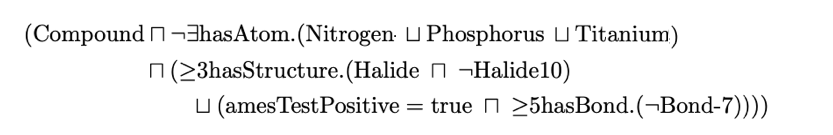

The part that is made simpler is the checking of the atoms, to implement that expression is only necessary to change the query 1 and make it more general (it does not deepen that much in the taxonomy)

* Query 1 simplified (*compound_and_NotHasAtom_General*): 

 $$Compound \ \cap \neg \exists hasAtom.(Nitrogen \cup Phosphorus  \cup Titanium)  $$


In [ ]:
#Query 1 simplified 
compound_and_NotHasAtom_General=prepareQuery('''
PREFIX
    xsd: <http://www.w3.org/2001/XMLSchema#>
ASK
WHERE{  SELECT ?nAtom
          WHERE{
            {SELECT 
                (COUNT (DISTINCT?atom) as ?nAtom)
            WHERE {
                ?compound carcinogenesis:hasAtom ?atom.
                ?atom a ?atomType.
                ?atomType rdfs:subClassOf ?parent
                FILTER( ?parent = carcinogenesis:Nitrogen || 
                        ?parent=  carcinogenesis:Titanium || 
                        ?parent=carcinogenesis:Phosphorus )
                                      
          }}FILTER(?nAtom = 0)}

 }
''',initNs = {"carcinogenesis": carcinogenesis})

# Function to check a compound with the simpler expression, receives the graph and 
# the compound to check.
def checkInstanceAtom(compound:str,graph:Graph)->bool:

  q1=graph.query(compound_and_NotHasAtom_General,initBindings={'?compound': URIRef(compound)})
  [r1]=list(q1)
  
  q2=graph.query(hasStructure_Halide,initBindings={'?compound': URIRef(compound)})
  [r2]=list(q2)
  
  q3=graph.query(amesTest_and_hasBond_Not7,initBindings={'?compound': URIRef(compound)})
  [r3]=list(q3)

  return r1 and (r2 or r3) 

In the following block we show some instances that we know could be susceptible to changes in classification when checked with the two expressions. Let´s see how they behave in the two situations proposed.

In [ ]:
print("\nd104")
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d104",g))
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d104",g))

print("\nd114")
print(checkInstance("http://dl-learner.org/carcinogenesis#d114",g))
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d114",g))

print("\nd110")

print(checkInstance("http://dl-learner.org/carcinogenesis#d110",g))
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d110",g))

print("\nd111")
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d111",g))
print(checkInstance("http://dl-learner.org/carcinogenesis#d111",g))

print("\nd7")
print(checkInstance("http://dl-learner.org/carcinogenesis#d7",g))
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d7",g))


print("\nd83")#MissClassified (it is a false positive)
print(checkInstance("http://dl-learner.org/carcinogenesis#d83",g))
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d83",g))


print("\nd226")#MissClassified (it is a false negative)
print(checkInstance("http://dl-learner.org/carcinogenesis#d226",g))
print(checkInstanceAtom("http://dl-learner.org/carcinogenesis#d226",g))



d104
True
True

d114
False
False

d110
False
False

d111
False
False

d7
True
False

d83
True
False

d226
False
False


We want the instances correctly classified in both graphs (the original and the one with the structures simplified) in order to get the accuracy.

In [ ]:
df=pd.DataFrame(data=positive+negative,columns=["Compound"])
df["Carcinogenic"]=df["Compound"].apply(func=lambda x: True if x in positive else False)

df["Explanation_Original"]=df["Compound"].apply(func=lambda x:checkInstance(x,g))
df_Original=df.loc[((df["Carcinogenic"] == True) & (df["Explanation_Original"] == True)| (df["Carcinogenic"] == False) & (df["Explanation_Original"] == False))]




df["Explanation_Atom"]=df["Compound"].apply(func=lambda x:checkInstanceAtom(x,g))
df_Atom=df.loc[((df["Carcinogenic"] == True) & (df["Explanation_Atom"] == True)| (df["Carcinogenic"] == False) & (df["Explanation_Atom"] == False))]


# Results of the simplification

To have a reference I show here the table found in https://dl-learner.org/community/carcinogenesis/ that serves us to check if we have well implemented the classification with the queries (the checkInstances function) and seems that we are within that range. 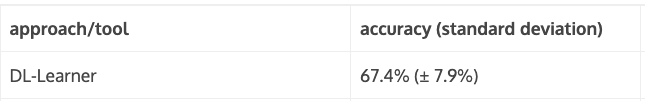)

In [ ]:
acc_NotPerturbed=(df_Original.shape[0]/298)*100
print("\nAccuracy Original Expression")
print(acc_NotPerturbed)



acc_Atom=(df_Atom.shape[0]/298)*100
print("\nAccuracy Atom is simplified in the explanation")
print(acc_Atom)



Accuracy Original Expression
72.14765100671141

Accuracy Atom is simplified in the explanation
56.711409395973156


# Perturbation of the instances

In this section we are making perturbations of the instances to see the stability of the explanation generated. 

First, to get an idea of how to implement the ontological perturbations explained in the statement we are only perturbing the atoms of the compounds.

### Perturbations of the Atoms

 In the case of atoms we will only allow perturbations that consist of a change of one isotope to another isotope of the same element, for example, if the compound has an atom of Carbon-22 it could become an atom of another isotope of only Carbon and no other element.

 Such implementation is in the block of code below.

In [ ]:
#Query to get all the atoms of the instance to be perturbed
qAtom = prepareQuery('''
  SELECT DISTINCT
    ?atom ?aType ?pType
  WHERE {
     ?compound carcinogenesis:hasAtom ?atom. 
     ?atom a ?aType.
     ?aType rdfs:subClassOf ?pType.
  }
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)

#Query to get all the isotopes of an element
qAtomSiblings = prepareQuery('''
  SELECT 
   ?sType
  WHERE { 
    ?sType rdfs:subClassOf ?compound.  
  }
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)

#Function to create the perturbations of the instance passed as argument
def perturbateAtoms(instance:str,graph:Graph):
  #The new instance (artificial instance created from the original one)
  per=rdflib.term.URIRef(instance+"_per")

  # We first remove any rest of previous perturbations
  graph.update('''
      DELETE {  
        ?atom a ?aType.      
        ?perturbated ?p ?o}
      WHERE { 
          ?perturbated carcinogenesis:hasAtom ?atom.
          ?atom a ?aType.  
          ?perturbated ?p ?o.
          }
  ''',
  initNs = { "carcinogenesis": carcinogenesis},initBindings={'?perturbated': per}
  ) 

  # We then  add all the relations of the original compound to the artificial instance 
  # except the atoms 
  graph.update('''
      INSERT {?perturbated ?p ?o}
      WHERE { 
          ?instance ?p ?o. FILTER( ?p != carcinogenesis:hasAtom)
          }
  ''',
  initNs = { "carcinogenesis": carcinogenesis},initBindings={'?instance': rdflib.term.URIRef(instance),'?perturbated':per}
  ) 


  #With this query we get all the atoms of the compound and their types as well as the type of the parent
  # r is in the form r=[(atom ,atomType,parentType),...]
  r=graph.query(qAtom,initBindings={'?compound': rdflib.term.URIRef(instance)})
  # For every atom in the compound we perturbate it
  for (atom ,atomType,parentType) in r:
     #With this query we get all the isotopes of the element 
     l=[r for (r,) in graph.query(qAtomSiblings,initBindings={'?compound':parentType})]
     #We add the atom perturbed
     graph.add((per,rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#hasAtom'),atom+"_p"))
     # The atom perturbed is an isotope randomly selected from the isotopes of the element
     graph.add((atom+"_p",rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),random.choice(l)))
 

**d104** 

Is  a carcinogenic compound and does not contain any atom of Nitrogen, Titanium or Phosphorus so a perturbation in the atoms does not change the classification.

In [ ]:
print("Originally d104: ")
checkInstance('http://dl-learner.org/carcinogenesis#d104',g)

Originally d104: 


True

In [ ]:
print("After Perturbation d104: ")
perturbateAtoms('http://dl-learner.org/carcinogenesis#d104',g)
checkInstance('http://dl-learner.org/carcinogenesis#d104_per',g)

After Perturbation d104: 


True

**d114**

Is not  a carcinogenic compound because it contains an atom of Nitrogen 35, but is susceptible of a change due to a perturbation in the atoms.

In [ ]:
print("Originally d114: ")
checkInstance('http://dl-learner.org/carcinogenesis#d114',g)

Originally d114: 


False

In [ ]:
print("After Perturbation d114: ")
perturbateAtoms('http://dl-learner.org/carcinogenesis#d114',g)
checkInstance('http://dl-learner.org/carcinogenesis#d114_per',g)

After Perturbation d114: 


True

In instances like d110 and d111 that the reason for not being carcinogenic is that they are missing Halide type structures or the AmesTest is negative, a perturbation in the atoms is not changing anything, so the explanation is very robust in that sense for those type of instances.

### Perturbation of the structures

In this section we are making perturbations of the instances to see the stability of the explanation generated. After the atoms, we want to see how the perturbations of the structure affects the classification

In [ ]:
#Query to get the structures of the instance to be perturbed
qStructure = prepareQuery('''
  SELECT DISTINCT
    ?structure ?sType ?pType
  WHERE { 
     ?compound carcinogenesis:hasStructure ?structure.
     ?structure a ?sType.
     ?sType rdfs:subClassOf ?pType. FILTER(?pType != carcinogenesis:Structure) 
  }
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)

#Query to get the substructures of an structure of an element
qStructureSiblings = prepareQuery('''
  SELECT 
   ?sType
  WHERE { 
    
    ?sType rdfs:subClassOf ?compound.
     
  }
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)

def perturbateStructures(instance:str,graph:Graph):
  #The new instance
  per=rdflib.term.URIRef(instance+"_per")
  
  #We add all the relations except the atoms and remove the previous perturbations
  graph.update('''
      DELETE {  
        ?structure a ?sType.      
        ?perturbated ?p ?o}
      WHERE { 
          ?perturbated carcinogenesis:hasStructure ?structure.
          ?structure a ?sType.  
          ?sType rdfs:subClassOf ?pType.
          FILTER(?pType != carcinogenesis:Structure)
          ?perturbated ?p ?o.
          }
  ''',
  initNs = { "carcinogenesis": carcinogenesis},initBindings={'?perturbated': per}
  ) 
  

  graph.update('''
      INSERT {?perturbated ?p ?o.
              ?perturbated carcinogenesis:hasStructure ?structure.
              ?structure a ?sType.
       }
      WHERE { 
          {?compound ?p ?o. FILTER( ?p != carcinogenesis:hasStructure)}
          UNION{ ?compound carcinogenesis:hasStructure ?structure.
                 ?structure a ?sType.
                 ?sType rdfs:subClassOf carcinogenesis:Structure.}
                
          }
  ''',
  initNs = { "carcinogenesis": carcinogenesis},initBindings={'?perturbated': per,"?compound":rdflib.term.URIRef(instance)}
  ) 
  
  #With this query we get all the structures of the compound and their types as well as the type of the parent
  r=graph.query(qStructure,initBindings={'?compound': rdflib.term.URIRef(instance)})
 
  # For every atom in the compound we perturbate it
  for (x,y,z) in r:
     
     #With this query we get the substrutures that has the same parent as the one we are perturbating
     l=[r for (r,) in graph.query(qStructureSiblings,initBindings={'?compound':z})]
     graph.add((per,rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#hasStructure'),x+"_p"))
     graph.add((x+"_p",rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),random.choice(l)))
 

An instance (classified as positive) that has many structures of type halide will be very unlikely to change its classification when perturbed because too many structures would have to be Halide-10 in order to make the count less than three, and that is verty unlikely although not imposible. Like we see in the example of 101.(The same happens to instances like d102,d103,d106 or d107)

**d101**

In [ ]:
checkInstance('http://dl-learner.org/carcinogenesis#d101',g)

True

In [ ]:
perturbateStructures('http://dl-learner.org/carcinogenesis#d101',g)
checkInstance('http://dl-learner.org/carcinogenesis#d101_per',g)

True

**d87**

d87 is more likely to change its classification due to the fact that is more likely to have less than 3 halide that are not halide-10 if a perturbation happens in the instance, because it only has 4 halide type structures.

In [ ]:
checkInstance('http://dl-learner.org/carcinogenesis#d87',g)

True

In [ ]:
perturbateStructures('http://dl-learner.org/carcinogenesis#d87',g)
checkInstance('http://dl-learner.org/carcinogenesis#d87_per',g)

False

With the query below we see that in total there are only 21 compounds that have amesTestPositive=False  and have a number of Halide structures between 3 and 6 so they are potentially vulnerable to a change in classification if perturbations happen. That is a small number of instances, so I would say that the classification is more stable in that part of the explanation.

In [ ]:
q2 = prepareQuery('''
SELECT  (COUNT(?compound) as ?count)   

WHERE{
  {SELECT 
    ?compound (COUNT(?structure) as ?count)
  WHERE { 

     ?compound carcinogenesis:hasStructure ?structure. 
     ?compound carcinogenesis:amesTestPositive false.
     ?structure a ?sType.
     ?sType rdfs:subClassOf carcinogenesis:Halide. 
  }GROUP BY ?compound}
FILTER(?count >= 3 && ?count <=6 )

}
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)


for x in g.query(q2):
  print(x)

(rdflib.term.Literal('21', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')),)


# Trial of a Stability Metric


## Similarity among instances 

What we want to do is to quantify the degree to which similar instances are classified the same. Taking the formula of the distance of [17] we are measuring the distance between instances as:

$$d(c_1, c_2)=\displaystyle\dfrac{ |  c_1 \cup c_2| -  |  c_1 \cap c_2|}{ |  c_1 \cup c_2|} $$

For implementing that formula we need a way of computing the union and interserction between compounds. It is implemented in the block of code below.

In [ ]:
#Receives two lists, one for each compound, each list is in the form 
# list_c1=[(istope, number), ....,(bond, number)], example: [(Carbon-32,15),(Bond-5,2), (Halide-10,4)]
def intersectionCompounds(c1:list, c2:list)-> dict:
  #We transform the lists into dict for commodity
  c1=dict(c1)
  c2=dict(c2)
  #The list that will contain the intersection
  intersection=[]
  # For each attribute in c1 if is in c2 add it to the intersection
  for x in c1.keys():
    if x in c2.keys():
            intersection.append((x, min(int(c1[x]),int(c2[x]))))
  return dict(intersection)


#Receives two lists, one for each compound, both lists are in the same format as in
# the intersection
def unionCompounds(c1:list, c2:list)-> dict:
  #The union list contains all the elements in c1
  union = dict([(x,int(y)) for (x,y) in c1])
  #and all the elements in c2
  for (x,y) in c2:
    if x in union.keys():
      union.update({x:max(int(y),union[x])}) 
    else :
      union.update({x:int(y)})

  return union

#With this query we get the attribute and the number of times it is in the compound
# the result of the query is used in the distance method
distanceQuery = prepareQuery('''
SELECT 
 ?aType (COUNT(?aType) as ?nType)
WHERE{

    {?compound carcinogenesis:hasAtom ?atom.
    ?atom a ?aType.}
    UNION {?compound carcinogenesis:hasStructure ?structure.
    ?structure a ?aType.}
    UNION {?compound carcinogenesis:hasBond ?bond.
    ?bond a ?aType.}
} Group by ?aType


  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)

#Distance function between two compounds
def distance(c1:str, c2:str)->float:
  c1_l = list(g.query(distanceQuery,initBindings={'?compound':rdflib.term.URIRef(c1)}))
  c2_l=list(g.query(distanceQuery,initBindings={'?compound':rdflib.term.URIRef(c2)}))
  union=sum(unionCompounds(c1_l,c2_l).values())
  intersection=sum(intersectionCompounds(c1_l,c2_l).values())

  return (union-intersection)/union

## Artificial Instances

In [ ]:
#Function to perturb a compound, receives the index of the perturbation to perform
def perturbationIth(instance,graph,i,attributes):
  #The number of attributes that we are chaging is between 1 and 5
  n=random.randint(1, 5)
  #We delete any rest of previous perturbations
  graph.update('''
      DELETE{?perturbated ?p1 ?o1.}
      INSERT {
        ?perturbated carcinogenesis:isPerturbationOf ?instance.
        ?perturbated ?p ?o.
       }
      WHERE { 
        {?instance ?p ?o.}
        UNION {?perturbated ?p1 ?o1.}   
          }
  ''',
  initNs = { "carcinogenesis": carcinogenesis},initBindings={'?instance':rdflib.term.URIRef(instance),'?perturbated':rdflib.term.URIRef(instance+"_per_"+str(i))}
  ) 
  #For the number of attributes to perturb
  for j in range(1,n):
    #The attribute to perturb, randomly selected
    (p,o,oType) = random.choice(attributes)

    siblings = list(graph.query('''
      SELECT 
       ?siblingsType
      WHERE{
          
          ?siblingsType rdfs:subClassOf ?pType.
          FILTER EXISTS{?oType rdfs:subClassOf ?pType.}
          }
           
    ''',
    initNs = { "carcinogenesis": carcinogenesis},initBindings={'?oType': oType}
    ))
    
    #With this update we change the attributes randomly selected to one of its siblings
    graph.update('''
          DELETE {?perturbated ?p ?o.}
          INSERT {?perturbated ?p ?oPer.
          ?oPer a ?oNewType. }
        WHERE{}
    ''',
    initNs = { "carcinogenesis": carcinogenesis},initBindings={'?perturbated':rdflib.term.URIRef(instance+"_per_"+str(i))
    ,'?p':p,'?o':o,'oPer':rdflib.term.URIRef(str(o)+'_p_'+str(i)+'_'+str(j)),'?oType':oType,'?oNewType':rdflib.term.URIRef(random.choice(siblings)[0]) }
    )
   


#With this method we are creating n artificial points near the real one
def artificialInstances(instance,graph,n=100):
  #Get the atoms, structures and bonds of the compound
  queryAttributes = prepareQuery('''
      SELECT 
      ?p ?o ?oType
      WHERE{
          ?instance ?p ?o.
          FILTER(?p =carcinogenesis:hasAtom || ?p = carcinogenesis:hasStructure || ?p = carcinogenesis:hasBond)
          ?o a ?oType.
          }
           
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
  )
  #The list of attributes 
  attributes=list(graph.query(queryAttributes,initBindings={'?instance':rdflib.term.URIRef(instance)}))
  #The number of attributes
  nAttributes=len(attributes)
  #We are making n perturbations
  #For the number of perturbations to create, call the method to create the artificial instance
  for i in range(0,n):
    perturbationIth(instance,graph,i,attributes)





## Stability 

The stability is going to be evaluated by following the formula:

$$\text{Stability of expression}= \dfrac{\displaystyle\sum_{m}^{i}  \sum_{j}^{n}  \lambda(c_i,c_{i.j}) \cdot d(c_i,c_{i.j}) }{n \cdot m}$$

In [ ]:
#Receives the list of instances in which the stability is going to be evaluated
def stabilityMetric(instances,graph,n=100):
  stability=0
  #For each compound
  for instance in instances:
    #We create the perturbations
    artificialInstances(instance,graph,n)
    

    #We get the classification for the real instance
    original_clasi=checkInstance(instance,graph)
    #A list of tuples that has the distance and the classification of the instance
    perturbations=[(checkInstance(instance+"_per_"+str(i),graph),distance(instance,instance+"_per_"+str(i))) for i in range(0,n)]

    stability=stability+sum([pertur[1] for pertur in perturbations if pertur[0] == original_clasi])

  return stability

In this block we implement a function for getting the comparison between the two expressions.

In [ ]:
def stabilityMetricComparison(instances,graph,n=100):
  stability1=0
  stability2=0
  for instance in instances:
    #We create the perturbations
    artificialInstances(instance,graph,n)
  
    #We get the classification for the real instance
    original_clasi1=checkInstance(instance,graph)
    #A list of tuples that has the distance and the classification of the instance
    perturbations1=[(checkInstance(instance+"_per_"+str(i),graph),distance(instance,instance+"_per_"+str(i))) for i in range(0,n)]
    stability1=stability1+sum([pertur[1] for pertur in perturbations1 if pertur[0] == original_clasi1])

    #We get the classification for the real instance
    original_clasi2=checkInstanceAtom(instance,graph)
    #A list of tuples that has the distance and the classification of the instance
    perturbations2=[(checkInstanceAtom(instance+"_per_"+str(i),graph),distance(instance,instance+"_per_"+str(i))) for i in range(0,n)]
    stability2=stability2+sum([pertur[1] for pertur in perturbations2 if pertur[0] == original_clasi2])
    
  return (stability1,stability2)

In [ ]:
stabilityMetric(['http://dl-learner.org/carcinogenesis#d114'],g)

22.374833626133675

We will now compare the two expressions over a set of manually selected instances that we have seen previously that and we consider it to be conflictive. As the stability measure is not deterministic we will run it 10 times and compare results.

In [ ]:
results=[]

for i in range(1,10):
  results.append(stabilityMetricComparison(['http://dl-learner.org/carcinogenesis#d114','http://dl-learner.org/carcinogenesis#d104','http://dl-learner.org/carcinogenesis#d110','http://dl-learner.org/carcinogenesis#d111','http://dl-learner.org/carcinogenesis#d7','http://dl-learner.org/carcinogenesis#d83','http://dl-learner.org/carcinogenesis#d226'],g))



(155.04467619999411, 181.08526062514247)
(183.20532123474018, 223.43746556060714)
(165.66287607865036, 191.8149511382668)
(184.17025211308675, 222.6701038840339)
(166.9766296157748, 191.78004481977433)
(178.37403407046224, 216.08409024581675)
(169.7185960581155, 193.35350880883936)
(177.40833842904007, 211.74407450515727)
(171.73044542358045, 199.52557900906305)


With these results we confirm our suspicions that the simpler expression (the column in the right) scores higher in terms of stability.

In [ ]:
results_normalized=[(result[0]/700,result[1]/700) for result in results]
results_normalized

[(0.22149239457142017, 0.25869322946448925),
 (0.26172188747820024, 0.3191963793722959),
 (0.23666125154092907, 0.27402135876895256),
 (0.26310036016155247, 0.31810014840576273),
 (0.23853804230824974, 0.2739714925996776),
 (0.2548200486720889, 0.30869155749402394),
 (0.2424551372258793, 0.27621929829834196),
 (0.25344048347005727, 0.30249153500736753),
 (0.24532920774797207, 0.28503654144151863)]

In [ ]:
stabilityMetricComparison(['http://dl-learner.org/carcinogenesis#d114','http://dl-learner.org/carcinogenesis#d104','http://dl-learner.org/carcinogenesis#d110','http://dl-learner.org/carcinogenesis#d111','http://dl-learner.org/carcinogenesis#d7','http://dl-learner.org/carcinogenesis#d83','http://dl-learner.org/carcinogenesis#d226'],g)

(178.52095179833967, 197.9801853661599)


(178.52095179833967, 197.9801853661599)

### **Example shown in the statement**

We are selecting the compound d105 for the example.

d105 has the following atoms:


In [ ]:
q = prepareQuery('''
SELECT
?atomType
WHERE{
  carcinogenesis:d105 carcinogenesis:hasAtom ?atom.
  ?atom a ?atomType.
}
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)


for (x,) in g.query(q):
  print(x)

http://dl-learner.org/carcinogenesis#Chlorine-93
http://dl-learner.org/carcinogenesis#Hydrogen-3
http://dl-learner.org/carcinogenesis#Carbon-16
http://dl-learner.org/carcinogenesis#Chlorine-93
http://dl-learner.org/carcinogenesis#Carbon-16
http://dl-learner.org/carcinogenesis#Chlorine-93


We perturb the compound creating 4 artificial instances from it

In [ ]:
artificialInstances('http://dl-learner.org/carcinogenesis#d105',g,n=4)

The peturbation number 2 has suffered a change in one of the atoms. We show the list of atoms of the artificial instance

In [ ]:
q = prepareQuery('''
SELECT
?atomType
WHERE{
  carcinogenesis:d105_per_2 carcinogenesis:hasAtom ?atom.
  ?atom a ?atomType.
}
  ''',
  initNs = { "carcinogenesis": carcinogenesis}
)


for (x,) in g.query(q):
  print(x)

http://dl-learner.org/carcinogenesis#Hydrogen-3
http://dl-learner.org/carcinogenesis#Chlorine-93
http://dl-learner.org/carcinogenesis#Chlorine-93
http://dl-learner.org/carcinogenesis#Carbon-16
http://dl-learner.org/carcinogenesis#Carbon-193
http://dl-learner.org/carcinogenesis#Chlorine-93


The distance between the two compounds (original and artificial) is:

In [ ]:
distance('http://dl-learner.org/carcinogenesis#d105','http://dl-learner.org/carcinogenesis#d105_per_2')

0.2